In [1]:
import ipywidgets as widgets

from google.cloud import storage
from datetime import datetime
from tqdm.notebook import tqdm
from IPython.display import display

# download the selected sample files
import tempfile

from fastavro import reader
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
%matplotlib notebook

from datetime import datetime

# Downloading Data

In [2]:
class Storage:
    def __init__(self):
        self.client = storage.Client(project='augury-ctoo')
        self.refresh_blobs()
        self.timestamps = []
        
    def refresh_blobs(self):
        self.blobs = []
        for blob in self.client.list_blobs("transformers-ae"):
            self.blobs.append(blob)

    def get_ids(self):
        ids = []
        for blob in self.blobs:
            id = blob.name.split("_")[0] + "_" + blob.name.split("_")[1]
            if id not in ids:
                ids.append(id)

        return ids
    
    def get_timestamps(self, id):
        timestamps = []
        for blob in self.blobs:
            if blob.name.split("_")[0] + "_" + blob.name.split("_")[1] != id:
                continue

            ts = int(blob.name.split("_")[2].split('.')[0])
            o = (datetime.utcfromtimestamp(ts), blob)
            if o not in timestamps:
                timestamps.append(o)
                
        return timestamps
    
def search(id):
    s.timestamps = s.get_timestamps(id)
    if len(s.timestamps) == 0:
        box2.layout = {'visibility': 'hidden'}
        return

    options = []
    for t in s.timestamps:
        options.append(t[0])
        
    selection_range_slider.options = options
    selection_range_slider.index = (0, len(options)-1)
    box2.layout = {'visibility': 'visible'}

def on_dropdown_change(d):
    search(d.new)
    
def on_go_button_clicked(h):
    global blobs
    blobs = []
    for t in s.timestamps[selection_range_slider.index[0]:selection_range_slider.index[1]+1]:
        blobs.append((t[0], t[1]))

In [3]:
s = Storage()

timestamps = [0]
selection_range_slider = widgets.SelectionRangeSlider(
    options=timestamps,
    index=(0, len(timestamps)-1),
    orientation='vertical',
    layout={'width': '500px'},
)

dropdown = widgets.Dropdown(
    options=s.get_ids(),
    description="id"
)

go_button = widgets.Button(description="go!")
box1 = widgets.HBox([dropdown])
box2 = widgets.VBox([selection_range_slider, go_button], layout={'visibility': 'hidden'})

 
dropdown.observe(on_dropdown_change, 'value')
search(dropdown.value)
(dropdown.options)

blobs = []

go_button.on_click(on_go_button_clicked)

widgets.VBox([box1, box2])

/usr/local/lib/python3.9/site-packages/google/auth/_default.py:73: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
path

'/var/folders/y7/k3j5759x5qlb_s8xycr9yln80000gq/T/tmpwwr2kjz5'

In [16]:
tempfiles = []
with tqdm(total=len(blobs)) as pbar:
    for (timestamp, blob) in blobs:
            pbar.set_description("Downloading %s" % blob.name)
            fd, path = tempfile.mkstemp()
            blob.download_to_filename(path)
            tempfiles.append((blob.name, path, timestamp)) #, dropdown.value))
            pbar.update(1)

  0%|          | 0/108 [00:00<?, ?it/s]

In [17]:
with tqdm(total=len(tempfiles)) as pbar:
    for (blob, path, timestamp) in tempfiles:
        with open(path, 'rb') as f:
            for d in reader(f):
                pbar.set_description("Exporting %s" % blob)
                periode = 1000 * 1 / d['samplerate']
                duration = np.arange(0, len(d['adc_signal_mv'][0]) * periode, periode)

                df = None
                if len(d['adc_signal_mv']) == 1:
                    df = pd.DataFrame(list(zip(duration, d['adc_signal_mv'][0])), columns=['time_ms', 'adc_signal_mv'])
                elif len(d['adc_signal_mv']) == 4:
                    df = pd.DataFrame(list(
                        zip(duration, 
                            d['adc_signal_mv'][0], 
                            d['adc_signal_mv'][1], 
                            d['adc_signal_mv'][2], 
                            d['adc_signal_mv'][3])), 
                            columns=['time_ms', 'ch0_adc_signal_mv', 'ch1_adc_signal_mv', 'ch2_adc_signal_mv', 'ch3_adc_signal_mv'])

                df.to_feather("data/{}.fthr".format(blob.split(".avro")[0]))
                pbar.update(1)

  0%|          | 0/108 [00:00<?, ?it/s]

# Processing data

In [1]:
def calc(file):
    import pandas as pd
    import numpy as np
    from scipy.signal import spectrogram
    from scipy.fft import fftfreq, fft
    
    def getThresh(x, nSTD=5):
        return np.std(x) * nSTD + np.median(x)
    
    def getCCoh(x, fs, norm=True):
        f, t, Sxx = spectrogram(x,
                                fs=fs, window='hann', 
                                nperseg=64, noverlap=32, nfft=256, 
                                detrend='constant', return_onesided=True, 
                                scaling='density', mode='psd')
        fMod = fftfreq(t.shape[0], d=t[1] - t[0])
        SxxDetrend = Sxx - np.atleast_2d(Sxx.mean(axis=1)).T
        CS = np.abs(fft(SxxDetrend))
        if norm:
            CS = np.abs(CS / np.atleast_2d(np.median(CS, axis=1)).T)
        CS[f < 50000, :] = 0
        return fMod, f, CS
    
    def getEESpec(CS, thresh=None):
        if thresh is None:
            thresh = getThresh(CS)
        CS[CS < thresh] = 0
        return CS.sum(axis=0)
    
    def getCCoh(x, fs, norm=True):
        f, t, Sxx = spectrogram(x,
                                fs=fs, window='hann', 
                                nperseg=64, noverlap=32, nfft=256, 
                                detrend='constant', return_onesided=True, 
                                scaling='density', mode='psd')
        fMod = fftfreq(t.shape[0], d=t[1] - t[0])
        SxxDetrend = Sxx - np.atleast_2d(Sxx.mean(axis=1)).T
        CS = np.abs(fft(SxxDetrend))
        if norm:
            CS = np.abs(CS / np.atleast_2d(np.median(CS, axis=1)).T)
        CS[f < 50000, :] = 0
        return fMod, f, CS

    df = pd.read_feather(file)
    fs = 1 / (df.iloc[1, 0] - df.iloc[0, 0]) * 1000
    x = df.iloc[:, 1].to_numpy()
    fMod, f, CCoh = getCCoh(x, fs, 3.5)

    cond = (fMod > 0) & (fMod < 310)
    vminVal = np.min(CCoh)
    vmaxVal = np.percentile(CCoh, 99.95)
    fMod = fMod[cond]
    CCoh = CCoh[:, cond]
    return getEESpec(CCoh, 3.5), fMod

In [4]:
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
%matplotlib notebook

files = sorted(glob("data/*.fthr"))
files = pd.Series(files)
files = pd.concat([files, files.str.split('/|16').apply(lambda x: x[1])], axis=1)
files.columns = ['name', 'sensor']
display(files.loc[:, 'sensor'].value_counts())
sensors = files.loc[:, 'sensor'].value_counts().index.to_list()

T7_ANALOGMAX-1_      243
T7_ANALOGMAX-0_      209
29.5_ANALOGMAX-0_    183
TRF01_IW976-0032_    145
29.5_ANALOGMAX-1_    129
TRF10_IW976-0032_    128
Name: sensor, dtype: int64

Starting 8 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

calc:   0%|          | 0/243 [00:00<?, ?tasks/s]

<IPython.core.display.Javascript object>


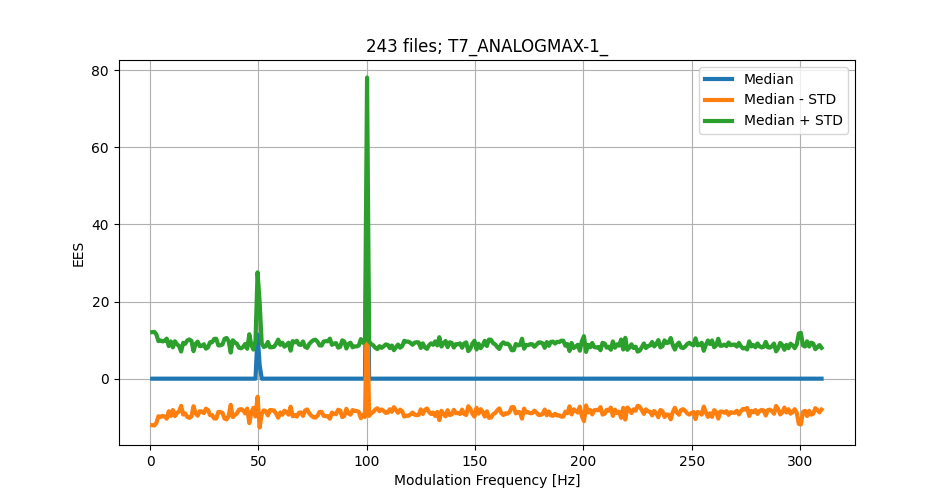

calc:   0%|          | 0/209 [00:00<?, ?tasks/s]

<IPython.core.display.Javascript object>


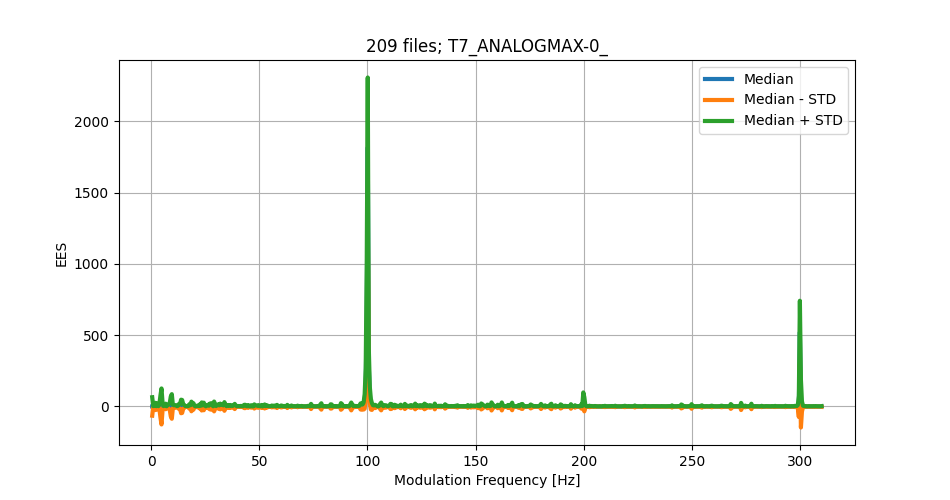

calc:   0%|          | 0/183 [00:00<?, ?tasks/s]

<IPython.core.display.Javascript object>


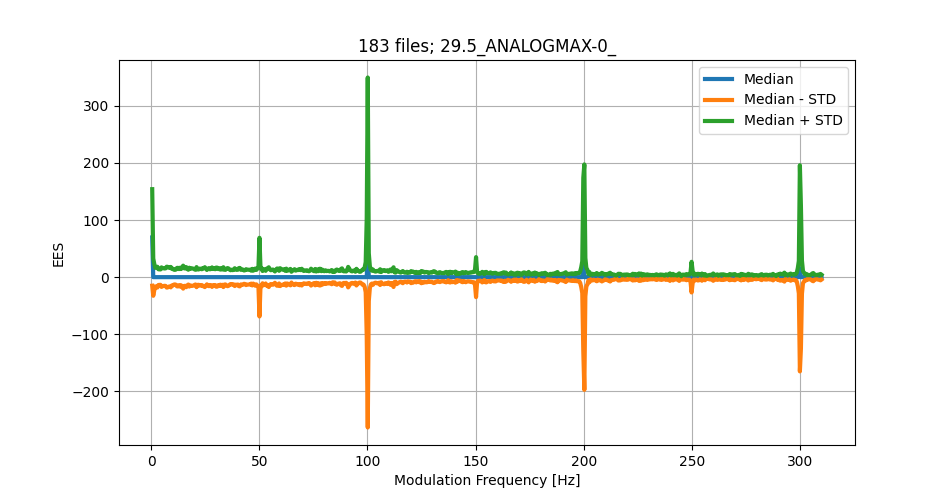

calc:   0%|          | 0/145 [00:00<?, ?tasks/s]

<IPython.core.display.Javascript object>


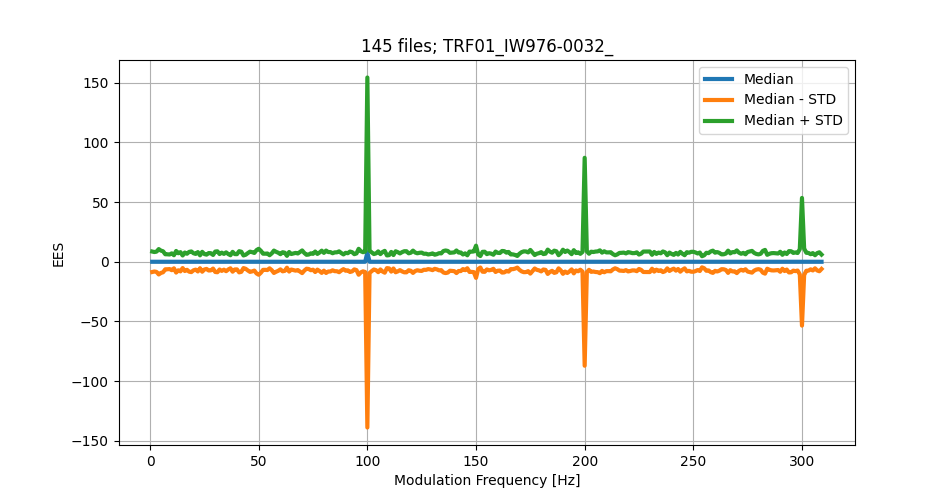

calc:   0%|          | 0/129 [00:00<?, ?tasks/s]

<IPython.core.display.Javascript object>


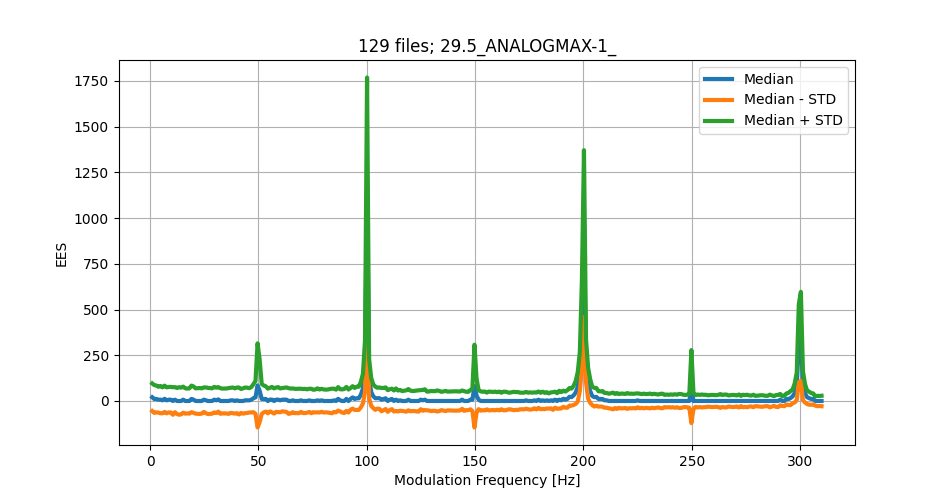

calc:   0%|          | 0/128 [00:00<?, ?tasks/s]

<IPython.core.display.Javascript object>


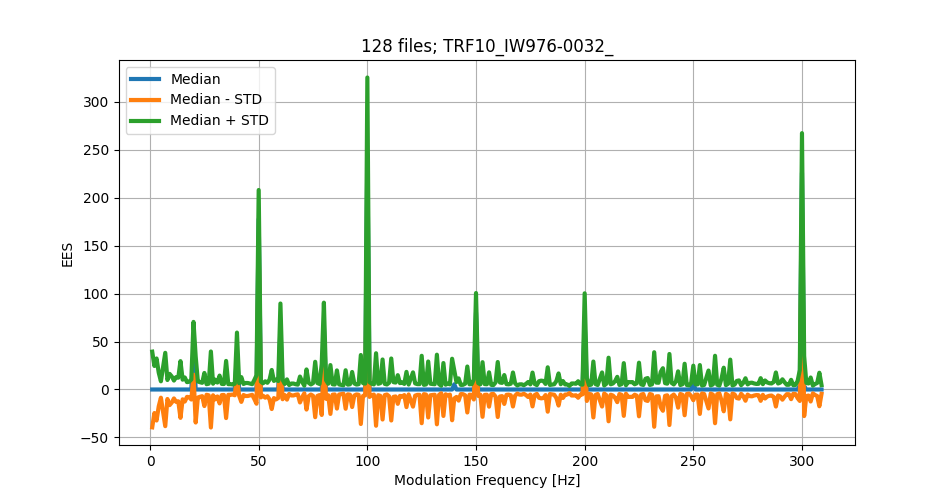

Stopping engine(s): 1642921783
engine set stopped 1642921783: {'engines': {'0': {'exit_code': 0, 'pid': 70486, 'identifier': '0'}, '1': {'exit_code': 0, 'pid': 70487, 'identifier': '1'}, '2': {'exit_code': 0, 'pid': 70488, 'identifier': '2'}, '3': {'exit_code': 0, 'pid': 70489, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 70490, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 70491, 'identifier': '5'}, '6': {'exit_code': 0, 'pid': 70492, 'identifier': '6'}, '7': {'exit_code': 0, 'pid': 70493, 'identifier': '7'}}, 'exit_code': 0}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 70474, 'identifier': 'ipcontroller-1642921782-g1ho-70408'}


In [5]:
import ipyparallel as ipp

with ipp.Cluster() as rc:
    # get a view on the cluster
    view = rc.load_balanced_view()
    for sensor in sensors:
        files = sorted(glob("data/{sensor}*.fthr".format(sensor=sensor)))
        # submit the tasks
        asyncresult = view.map_async(calc, files)
        # wait interactively for results
        asyncresult.wait_interactive()
        # retrieve actual results
        res = asyncresult.get()
        fMod = res[0][1]
        res = [r[0] for r in res]

        plt.figure(figsize=[9.5, 5])
        plt.title(str(len(files)) + " files; " + sensor)
        plt.plot(fMod, np.median(res, axis=0), linewidth=3)
        plt.plot(fMod, np.median(res, axis=0) - np.std(res, axis=0), linewidth=3)
        plt.plot(fMod, np.median(res, axis=0) + np.std(res, axis=0), linewidth=3)
        plt.xlabel(r'Modulation Frequency [Hz]')
        plt.ylabel('EES')
        plt.legend(['Median', 'Median - STD', 'Median + STD'])
        plt.grid()
        plt.show()

In [ ]:
#     plt.figure(figsize=[9.5, 5])
#     plt.pcolormesh(fMod, f, CCoh, vmin = vminVal, vmax = vmaxVal)
#     plt.ylabel('Carrier Frequency [Hz]')
#     plt.xlabel(r'Modulation Frequency [Hz]')
#     plt.title(file)
#     plt.show()

#     plt.figure(figsize=[9.5, 5])
#     plt.plot(fMod,res[-1] , linewidth=3)
#     plt.grid()
#     plt.show()